# Problem Statement

"Dalam era modern, **masalah kebotakan** menjadi perhatian yang semakin besar bagi banyak individu di seluruh dunia. Namun, meskipun prevalensinya cukup tinggi, faktor-faktor yang berkontribusi terhadap kebotakan masih belum sepenuhnya dipahami. 

Untuk mengatasi ketidakpastian ini, pengumpulan dan analisis data tentang probabilitas kebotakan menjadi sangat penting. Dataset probabilitas kebotakan menawarkan wawasan yang berharga tentang faktor-faktor risiko yang mungkin mempengaruhi kebotakan, seperti **faktor umur, jenis_kelamin, gaji, sampo, dan lain-lain**. Dengan memahami hubungan antara variabel-variabel ini, dapat mengembangkan strategi pencegahan yang lebih efektif dan solusi terapeutik yang lebih tepat sasaran untuk mengatasi masalah kebotakan."

# Import Libraries

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from datetime import datetime

# encoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold

# feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Search CV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler

import warnings
warnings.filterwarnings("ignore")

# menampilkan semua kolom
pd.set_option('display.max_columns', None)

# EDA and Data Preprocessing

## Load Data

In [2]:
df = pd.read_csv('Case Study Chapter 3 Topic 3_ Dataset Kebotakan (Not Clean).csv')

In [3]:
df.head()

,umur,jenis_kelamin,pekerjaan,provinsi,gaji,is_menikah,is_keturunan,berat,tinggi,sampo,is_merokok,pendidikan,stress,botak_prob
0,27.0,Perempuan,PNS,Bengkulu,7.957453e+06,1.0,0.0,54.315053,170.428542,Pantone,1.0,S1,5.0,0.605974
1,53.0,Perempuan,PNS,Bandung,7.633003e+06,1.0,0.0,72.873404,165.530097,Pantone,0.0,S1,7.0,0.532860
2,37.0,Perempuan,Pegawai swasta,Bandung,6.637625e+06,1.0,0.0,46.321533,154.599388,Moonsilk,0.0,S1,4.0,0.418442
3,36.0,Perempuan,Pengangguran,Palu,3.624871e+06,1.0,0.0,51.539781,167.340481,Deadbuoy,1.0,SD,9.0,0.804050
4,38.0,Laki-laki,Freelance,Palangkaraya,6.031808e+06,1.0,0.0,60.726909,165.514773,Merpati,1.0,S2,1.0,0.368371


## Data Cleaning

In [4]:
# melihat missing value dan duplicate value
datasets = [df]
titles = ['dataset_kebotakan']

data_summary = pd.DataFrame({},)
data_summary['datasets']= titles
data_summary['columns'] = [', '.join([col for col, null in data.isnull().sum().items() ]) for data in datasets]
data_summary['total_rows']= [data.shape[0] for data in datasets]
data_summary['total_cols']= [data.shape[1] for data in datasets]
data_summary['total_duplicate']= [len(data[data.duplicated()]) for data in datasets]
data_summary['total_null']= [data.isnull().sum().sum() for data in datasets]
data_summary['null_cols'] = [', '.join([col for col, null in data.isnull().sum().items() if null > 0]) for data in datasets]
data_summary.style.background_gradient(cmap='Greens_r')

,datasets,columns,total_rows,total_cols,total_duplicate,total_null,null_cols
0,dataset_kebotakan,"umur, jenis_kelamin, pekerjaan, provinsi, gaji, is_menikah, is_keturunan, berat, tinggi, sampo, is_merokok, pendidikan, stress, botak_prob",7917,14,82,1112,"umur, jenis_kelamin, pekerjaan, provinsi, gaji, is_menikah, is_keturunan, berat, tinggi, sampo, is_merokok, pendidikan, stress, botak_prob"


In [5]:
# menghapus data yang duplicate
df = df.drop_duplicates()

In [6]:
df.describe()

,umur,gaji,is_menikah,is_keturunan,berat,tinggi,is_merokok,stress,botak_prob
count,7750.000000,7.762000e+03,7765.000000,7747.000000,7779.000000,7761.000000,7766.000000,7771.000000,7757.000000
mean,39.490065,8.842005e+06,0.979008,0.204983,55.953868,167.238538,0.498069,5.450907,0.573762
std,9.885476,4.484863e+06,0.143365,0.403715,9.589066,10.943226,0.500028,2.863205,0.173528
min,2.000000,1.500000e+06,0.000000,0.000000,40.000000,125.491784,0.000000,1.000000,0.064633
25%,33.000000,5.729925e+06,1.000000,0.000000,49.309668,159.746997,0.000000,3.000000,0.451812
50%,39.000000,7.837840e+06,1.000000,0.000000,53.843172,167.136415,0.000000,5.000000,0.567963
75%,46.000000,1.081619e+07,1.000000,0.000000,60.262151,174.440998,1.000000,8.000000,0.686788
max,77.000000,5.000000e+07,1.000000,1.000000,150.000000,226.454577,1.000000,10.000000,1.000000


In [7]:
# mengatasi null value pada kolom numerical
df['umur'] = df['umur'].fillna(df['umur'].mode()[0])
df['gaji'] = df['gaji'].fillna(df['gaji'].mean())
df['berat'] = df['berat'].fillna(df['berat'].mean())
df['tinggi'] = df['tinggi'].fillna(df['tinggi'].mean())
df['stress'] = df['stress'].fillna(df['stress'].mode()[0])
df['botak_prob'] = df['botak_prob'].fillna(df['botak_prob'].mean())

In [8]:
df['is_menikah'].value_counts()

is_menikah
1.0    7602
0.0     163
Name: count, dtype: int64

In [9]:
df['is_keturunan'].value_counts()

is_keturunan
0.0    6159
1.0    1588
Name: count, dtype: int64

In [10]:
# mengatasi null value pada tipe data boolean
df['is_merokok'] = df['is_merokok'].fillna(df['is_merokok'].mode()[0])
df['is_menikah'] = df['is_menikah'].fillna(0)
df['is_keturunan'] = df['is_keturunan'].fillna(0)

In [11]:
#df[(df['is_menikah'] == 0) & (df['is_keturunan'] == 1)]

In [12]:
#df.loc[(df['is_menikah'] == 0) & (df['is_keturunan'] == 1), 'is_keturunan'] = 0

In [13]:
#df[(df['is_menikah'] == 0) & (df['is_keturunan'] == 1)]

In [14]:
df.isnull().sum()

umur               0
jenis_kelamin     75
pekerjaan        154
provinsi          86
gaji               0
is_menikah         0
is_keturunan       0
berat              0
tinggi             0
sampo             59
is_merokok         0
pendidikan        69
stress             0
botak_prob         0
dtype: int64

In [15]:
# melihat konsistensi data dan null value
cat = ['jenis_kelamin', 'pekerjaan', 'provinsi', 'sampo', 'pendidikan']
for col in cat:
    print(col)
    print(df[col].unique())
    print('type data:', df[col].dtype)
    print('\n')

jenis_kelamin
['Perempuan' 'Laki-laki' nan]
type data: object


pekerjaan
['PNS' 'Pegawai swasta' 'Pengangguran' 'Freelance' nan]
type data: object


provinsi
['Bengkulu' 'Bandung' 'Palu' 'Palangkaraya' 'Serang' 'Banda Aceh'
 'Palembang' 'Kupang' 'Sofifi' 'Ambon' 'Tanjungselor' 'Tanjung Pinang'
 'Banjarmasin' 'Denpasar' 'Mamuju' 'Makassar' 'Pangkalpinang' 'Yogyakarta'
 'Pontianak' 'Mataram' 'Manokwari' 'Gorontalo' 'Semarang' 'Surabaya'
 'Jakarta' 'Banda Lampung' 'Kendari' 'Pekanbaru' 'Jayapura' 'Jambi'
 'Manado' 'Medan' 'Samarinda' nan 'Padang']
type data: object


sampo
['Pantone' 'Moonsilk' 'Deadbuoy' 'Merpati' 'Shoulder & Head' nan]
type data: object


pendidikan
['S1' 'SD' 'S2' 'SMA' 'SMP' 'S3' nan]
type data: object




In [16]:
# mengatasi null value pada kolom categorical
df['jenis_kelamin'] = df['jenis_kelamin'].fillna(df['jenis_kelamin'].mode()[0])
df['pekerjaan'] = df['pekerjaan'].fillna('Others')
df['provinsi'] = df['provinsi'].fillna('Others')
df['sampo'] = df['sampo'].fillna('Others')
df['pendidikan'] = df['pendidikan'].fillna('Others')

In [17]:
# melihat missing value dan duplicate value
datasets = [df]
titles = ['dataset_kebotakan']

data_summary = pd.DataFrame({},)
data_summary['datasets']= titles
data_summary['columns'] = [', '.join([col for col, null in data.isnull().sum().items() ]) for data in datasets]
data_summary['total_rows']= [data.shape[0] for data in datasets]
data_summary['total_cols']= [data.shape[1] for data in datasets]
data_summary['total_duplicate']= [len(data[data.duplicated()]) for data in datasets]
data_summary['total_null']= [data.isnull().sum().sum() for data in datasets]
data_summary['null_cols'] = [', '.join([col for col, null in data.isnull().sum().items() if null > 0]) for data in datasets]
data_summary.style.background_gradient(cmap='Greens_r')

,datasets,columns,total_rows,total_cols,total_duplicate,total_null,null_cols
0,dataset_kebotakan,"umur, jenis_kelamin, pekerjaan, provinsi, gaji, is_menikah, is_keturunan, berat, tinggi, sampo, is_merokok, pendidikan, stress, botak_prob",7835,14,0,0,


## Exploratory Data Analysis (EDA)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7835 entries, 0 to 7834
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   umur           7835 non-null   float64
 1   jenis_kelamin  7835 non-null   object 
 2   pekerjaan      7835 non-null   object 
 3   provinsi       7835 non-null   object 
 4   gaji           7835 non-null   float64
 5   is_menikah     7835 non-null   float64
 6   is_keturunan   7835 non-null   float64
 7   berat          7835 non-null   float64
 8   tinggi         7835 non-null   float64
 9   sampo          7835 non-null   object 
 10  is_merokok     7835 non-null   float64
 11  pendidikan     7835 non-null   object 
 12  stress         7835 non-null   float64
 13  botak_prob     7835 non-null   float64
dtypes: float64(9), object(5)
memory usage: 918.2+ KB


In [19]:
df.head()

,umur,jenis_kelamin,pekerjaan,provinsi,gaji,is_menikah,is_keturunan,berat,tinggi,sampo,is_merokok,pendidikan,stress,botak_prob
0,27.0,Perempuan,PNS,Bengkulu,7.957453e+06,1.0,0.0,54.315053,170.428542,Pantone,1.0,S1,5.0,0.605974
1,53.0,Perempuan,PNS,Bandung,7.633003e+06,1.0,0.0,72.873404,165.530097,Pantone,0.0,S1,7.0,0.532860
2,37.0,Perempuan,Pegawai swasta,Bandung,6.637625e+06,1.0,0.0,46.321533,154.599388,Moonsilk,0.0,S1,4.0,0.418442
3,36.0,Perempuan,Pengangguran,Palu,3.624871e+06,1.0,0.0,51.539781,167.340481,Deadbuoy,1.0,SD,9.0,0.804050
4,38.0,Laki-laki,Freelance,Palangkaraya,6.031808e+06,1.0,0.0,60.726909,165.514773,Merpati,1.0,S2,1.0,0.368371


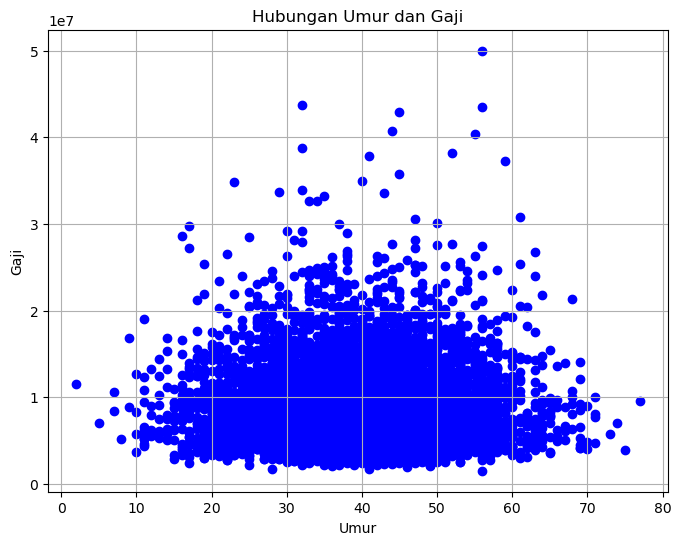

In [20]:
# hubungan umur dan gaji
plt.figure(figsize=(8, 6))
plt.scatter(df['umur'], df['gaji'], color='blue')
plt.title('Hubungan Umur dan Gaji')
plt.xlabel('Umur')
plt.ylabel('Gaji')
plt.grid(True)
plt.show()

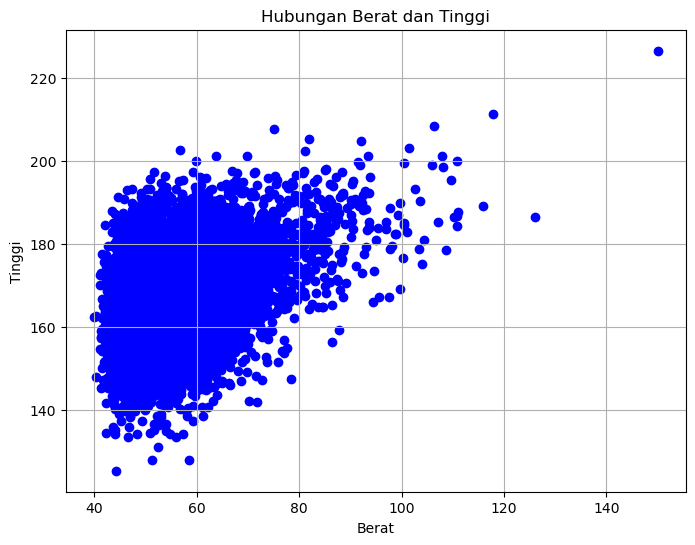

In [21]:
# hubungan berat dan tinggi
plt.figure(figsize=(8, 6))
plt.scatter(df['berat'], df['tinggi'], color='blue')
plt.title('Hubungan Berat dan Tinggi')
plt.xlabel('Berat')
plt.ylabel('Tinggi')
plt.grid(True)
plt.show()

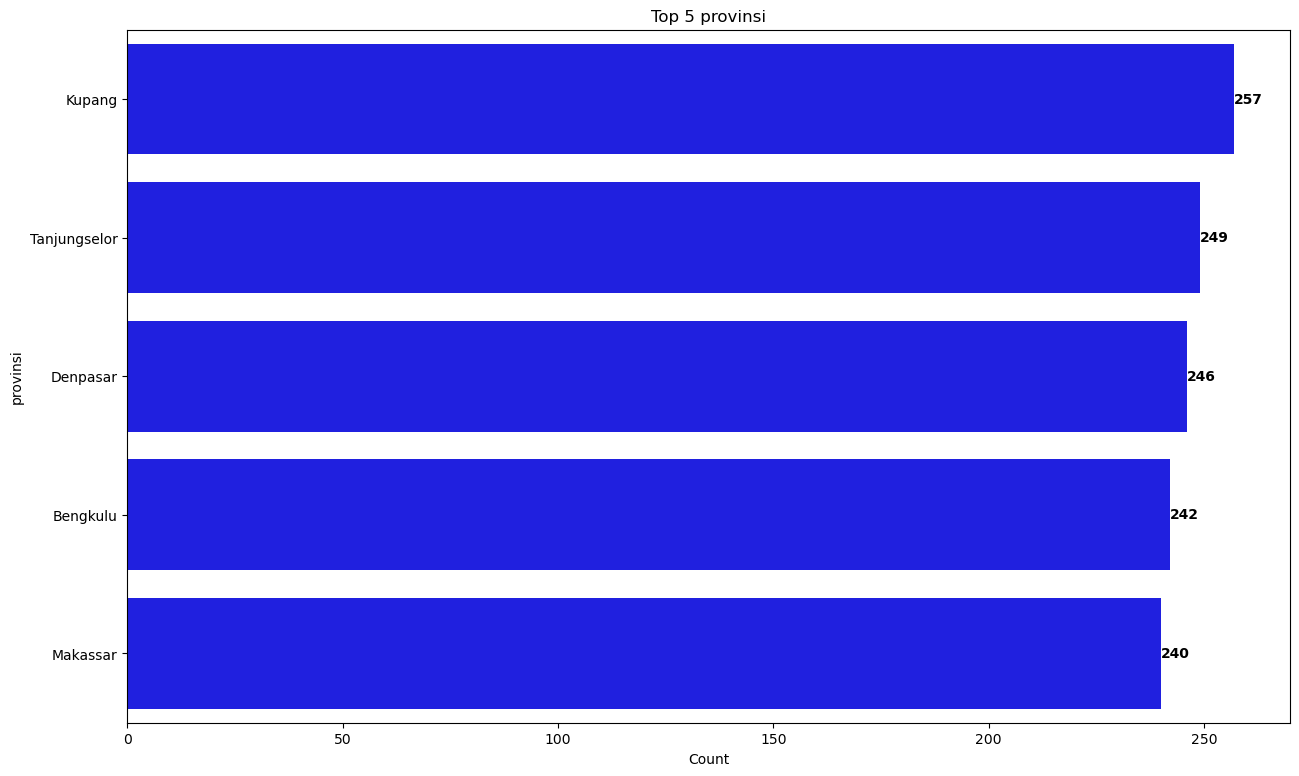

In [22]:
# bar chart berdasarkan provinsi

# menghitung frekuensi kolom 'provinsi'
provinsi_counts = df['provinsi'].value_counts()

# memilih 5 data teratas
top_5_provinsi = provinsi_counts.head(5)

# Membuat bar chart
fig = plt.figure(figsize=(15, 9))
ax = sns.barplot(y=top_5_provinsi.index, x=top_5_provinsi.values, order=top_5_provinsi.index, color="Blue")
plt.title("Top 5 provinsi")
plt.xlabel("Count")
plt.ylabel("provinsi")

# menambahkan jumlah label di atas setiap bar
for i, count in enumerate(top_5_provinsi.values):
    plt.text(count, i, f'{count}', ha='left', va='center', fontsize=10, color='black', weight='bold')

plt.show()

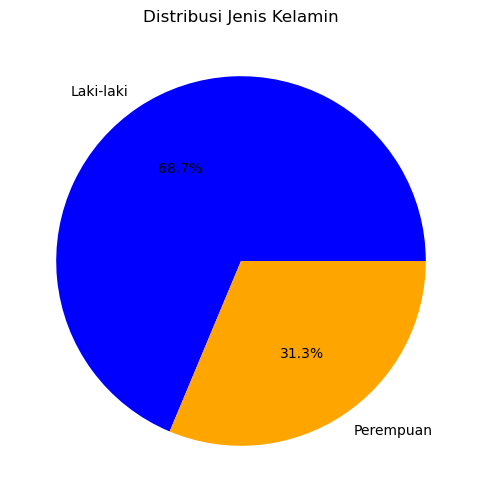

In [23]:
# pie chart jenis_kelamin
counts = df['jenis_kelamin'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', colors=['blue', 'orange'])
plt.title('Distribusi Jenis Kelamin')
plt.show()

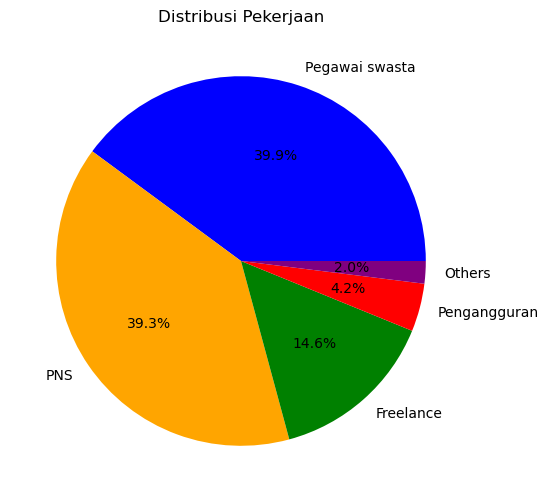

In [24]:
# pie chart pekerjaan
counts = df['pekerjaan'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', colors=['blue', 'orange', 'green', 'red', 'purple'])
plt.title('Distribusi Pekerjaan')
plt.show()

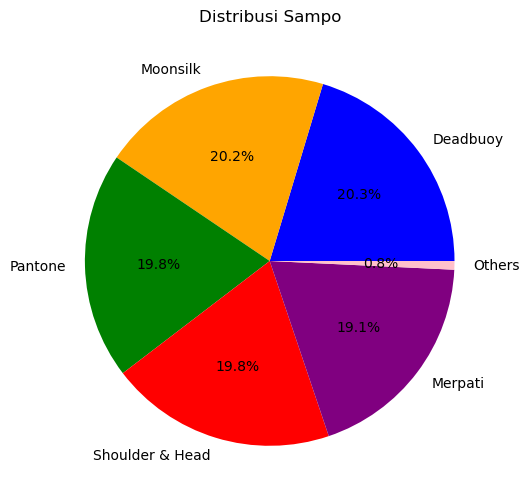

In [25]:
# pie chart sampo
counts = df['sampo'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', colors=['blue', 'orange', 'green', 'red', 'purple', 'pink'])
plt.title('Distribusi Sampo')
plt.show()

In [26]:
# jenis_kelamin dan pekerjaan
total = df.shape[0]
df1 = df.groupby(['jenis_kelamin', 'pekerjaan']).size().reset_index(name='count')
df1['total'] = total
df1['percentage'] = round((df1['count'] / df1['total']) * 100, 2)

df1

,jenis_kelamin,pekerjaan,count,total,percentage
0,Laki-laki,Freelance,770,7835,9.83
1,Laki-laki,Others,104,7835,1.33
2,Laki-laki,PNS,2128,7835,27.16
3,Laki-laki,Pegawai swasta,2140,7835,27.31
4,Laki-laki,Pengangguran,240,7835,3.06
5,Perempuan,Freelance,376,7835,4.80
6,Perempuan,Others,50,7835,0.64
7,Perempuan,PNS,953,7835,12.16
8,Perempuan,Pegawai swasta,985,7835,12.57
9,Perempuan,Pengangguran,89,7835,1.14


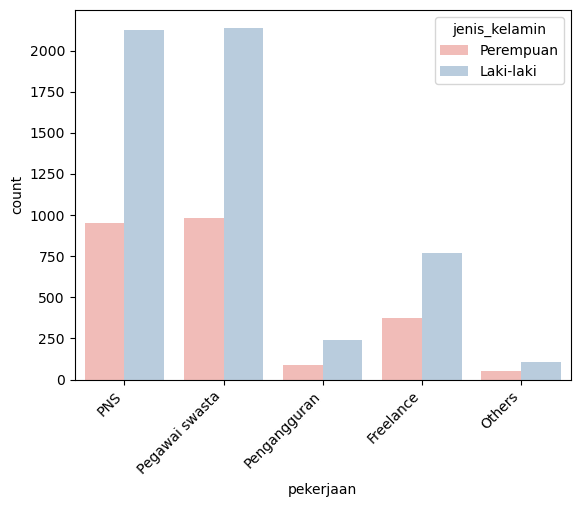

In [27]:
# visualisasi jenis_kelamin dan pekerjaan
ax = sns.countplot(x='pekerjaan', hue = 'jenis_kelamin', data = df, palette='Pastel1')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.show()

In [28]:
# jenis_kelamin dan sampo
total = df.shape[0]
df2 = df.groupby(['jenis_kelamin', 'sampo']).size().reset_index(name='count')
df2['total'] = total
df2['percentage'] = round((df2['count'] / df2['total']) * 100, 2)

df2

,jenis_kelamin,sampo,count,total,percentage
0,Laki-laki,Deadbuoy,1078,7835,13.76
1,Laki-laki,Merpati,1004,7835,12.81
2,Laki-laki,Moonsilk,1076,7835,13.73
3,Laki-laki,Others,42,7835,0.54
4,Laki-laki,Pantone,1107,7835,14.13
5,Laki-laki,Shoulder & Head,1075,7835,13.72
6,Perempuan,Deadbuoy,516,7835,6.59
7,Perempuan,Merpati,490,7835,6.25
8,Perempuan,Moonsilk,506,7835,6.46
9,Perempuan,Others,17,7835,0.22


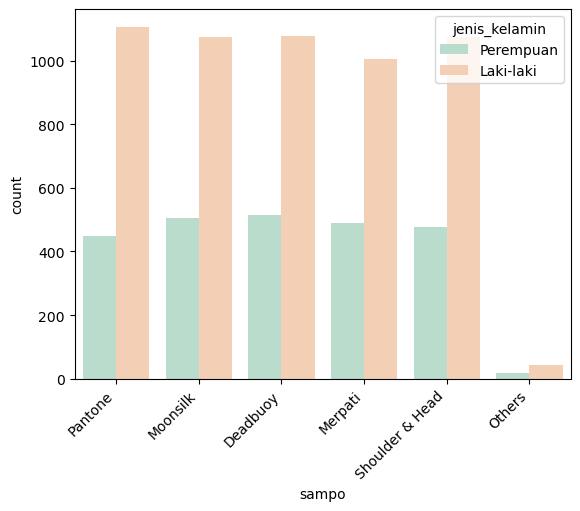

In [29]:
# visualisasi jenis_kelamin dan sampo
ax = sns.countplot(x='sampo', hue = 'jenis_kelamin', data = df, palette='Pastel2')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.show()

In [30]:
df.head()

,umur,jenis_kelamin,pekerjaan,provinsi,gaji,is_menikah,is_keturunan,berat,tinggi,sampo,is_merokok,pendidikan,stress,botak_prob
0,27.0,Perempuan,PNS,Bengkulu,7.957453e+06,1.0,0.0,54.315053,170.428542,Pantone,1.0,S1,5.0,0.605974
1,53.0,Perempuan,PNS,Bandung,7.633003e+06,1.0,0.0,72.873404,165.530097,Pantone,0.0,S1,7.0,0.532860
2,37.0,Perempuan,Pegawai swasta,Bandung,6.637625e+06,1.0,0.0,46.321533,154.599388,Moonsilk,0.0,S1,4.0,0.418442
3,36.0,Perempuan,Pengangguran,Palu,3.624871e+06,1.0,0.0,51.539781,167.340481,Deadbuoy,1.0,SD,9.0,0.804050
4,38.0,Laki-laki,Freelance,Palangkaraya,6.031808e+06,1.0,0.0,60.726909,165.514773,Merpati,1.0,S2,1.0,0.368371


In [31]:
# pekerjaan dan pendidikan
total = df.shape[0]
df3 = df.groupby(['pekerjaan', 'pendidikan']).size().reset_index(name='count')
df3['total'] = total
df3['percentage'] = round((df3['count'] / df3['total']) * 100, 2)
#df3 = df3.sort_values(by='percentage', ascending=False)

df3

,pekerjaan,pendidikan,count,total,percentage
0,Freelance,Others,11,7835,0.14
1,Freelance,S1,633,7835,8.08
2,Freelance,S2,97,7835,1.24
3,Freelance,S3,21,7835,0.27
4,Freelance,SD,30,7835,0.38
5,Freelance,SMA,277,7835,3.54
6,Freelance,SMP,77,7835,0.98
7,Others,Others,2,7835,0.03
8,Others,S1,77,7835,0.98
9,Others,S2,8,7835,0.10


In [32]:
# is_merokok dan stress
total = df.shape[0]
df4 = df.groupby(['is_merokok', 'stress']).size().reset_index(name='count')
df4['total'] = total
df4['percentage'] = round((df4['count'] / df4['total']) * 100, 2)
df4 = df4.sort_values(by='percentage', ascending=False)

df4

,is_merokok,stress,count,total,percentage
13,1.0,4.0,474,7835,6.05
3,0.0,4.0,442,7835,5.64
8,0.0,9.0,430,7835,5.49
7,0.0,8.0,422,7835,5.39
15,1.0,6.0,421,7835,5.37
0,0.0,1.0,414,7835,5.28
12,1.0,3.0,400,7835,5.11
1,0.0,2.0,397,7835,5.07
2,0.0,3.0,393,7835,5.02
14,1.0,5.0,385,7835,4.91


In [33]:
# jenis_kelamin, is_menikah, dan is_keturunan
total = df.shape[0]
df5 = df.groupby(['jenis_kelamin', 'is_menikah', 'is_keturunan']).size().reset_index(name='count')
df5['total'] = total
df5['percentage'] = round((df5['count'] / df5['total']) * 100, 2)
#df5 = df5.sort_values(by='percentage', ascending=False)

df5

,jenis_kelamin,is_menikah,is_keturunan,count,total,percentage
0,Laki-laki,0.0,0.0,127,7835,1.62
1,Laki-laki,0.0,1.0,32,7835,0.41
2,Laki-laki,1.0,0.0,4180,7835,53.35
3,Laki-laki,1.0,1.0,1043,7835,13.31
4,Perempuan,0.0,0.0,56,7835,0.71
5,Perempuan,0.0,1.0,18,7835,0.23
6,Perempuan,1.0,0.0,1884,7835,24.05
7,Perempuan,1.0,1.0,495,7835,6.32


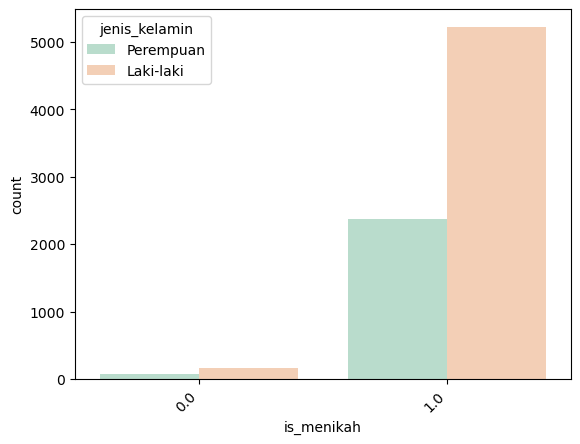

In [34]:
# visualisasi jenis_kelamin dan is_menikah
ax = sns.countplot(x='is_menikah', hue = 'jenis_kelamin', data = df, palette='Pastel2')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.show()

In [35]:
df.head()

,umur,jenis_kelamin,pekerjaan,provinsi,gaji,is_menikah,is_keturunan,berat,tinggi,sampo,is_merokok,pendidikan,stress,botak_prob
0,27.0,Perempuan,PNS,Bengkulu,7.957453e+06,1.0,0.0,54.315053,170.428542,Pantone,1.0,S1,5.0,0.605974
1,53.0,Perempuan,PNS,Bandung,7.633003e+06,1.0,0.0,72.873404,165.530097,Pantone,0.0,S1,7.0,0.532860
2,37.0,Perempuan,Pegawai swasta,Bandung,6.637625e+06,1.0,0.0,46.321533,154.599388,Moonsilk,0.0,S1,4.0,0.418442
3,36.0,Perempuan,Pengangguran,Palu,3.624871e+06,1.0,0.0,51.539781,167.340481,Deadbuoy,1.0,SD,9.0,0.804050
4,38.0,Laki-laki,Freelance,Palangkaraya,6.031808e+06,1.0,0.0,60.726909,165.514773,Merpati,1.0,S2,1.0,0.368371


In [36]:
# is_merokok dan pendidikan
total = df.shape[0]
df6 = df.groupby(['is_merokok', 'pendidikan']).size().reset_index(name='count')
df6['total'] = total
df6['percentage'] = round((df6['count'] / df6['total']) * 100, 2)
#df6 = df6.sort_values(by='percentage', ascending=False)

df6

,is_merokok,pendidikan,count,total,percentage
0,0.0,Others,34,7835,0.43
1,0.0,S1,2183,7835,27.86
2,0.0,S2,315,7835,4.02
3,0.0,S3,81,7835,1.03
4,0.0,SD,114,7835,1.46
5,0.0,SMA,982,7835,12.53
6,0.0,SMP,258,7835,3.29
7,1.0,Others,35,7835,0.45
8,1.0,S1,2076,7835,26.50
9,1.0,S2,286,7835,3.65


In [65]:
# is_menikah dan stress
total = df.shape[0]
df7 = df.groupby(['is_menikah', 'stress']).size().reset_index(name='count')
df7['total'] = total
df7['percentage'] = round((df7['count'] / df7['total']) * 100, 2)
df7 = df7.sort_values(by='percentage', ascending=False)

df7

,is_menikah,stress,count,total,percentage
13,1.0,4.0,886,7835,11.31
10,1.0,1.0,774,7835,9.88
12,1.0,3.0,770,7835,9.83
17,1.0,8.0,769,7835,9.81
15,1.0,6.0,765,7835,9.76
18,1.0,9.0,758,7835,9.67
11,1.0,2.0,743,7835,9.48
16,1.0,7.0,721,7835,9.20
14,1.0,5.0,713,7835,9.10
19,1.0,10.0,703,7835,8.97


## Handling Outliers

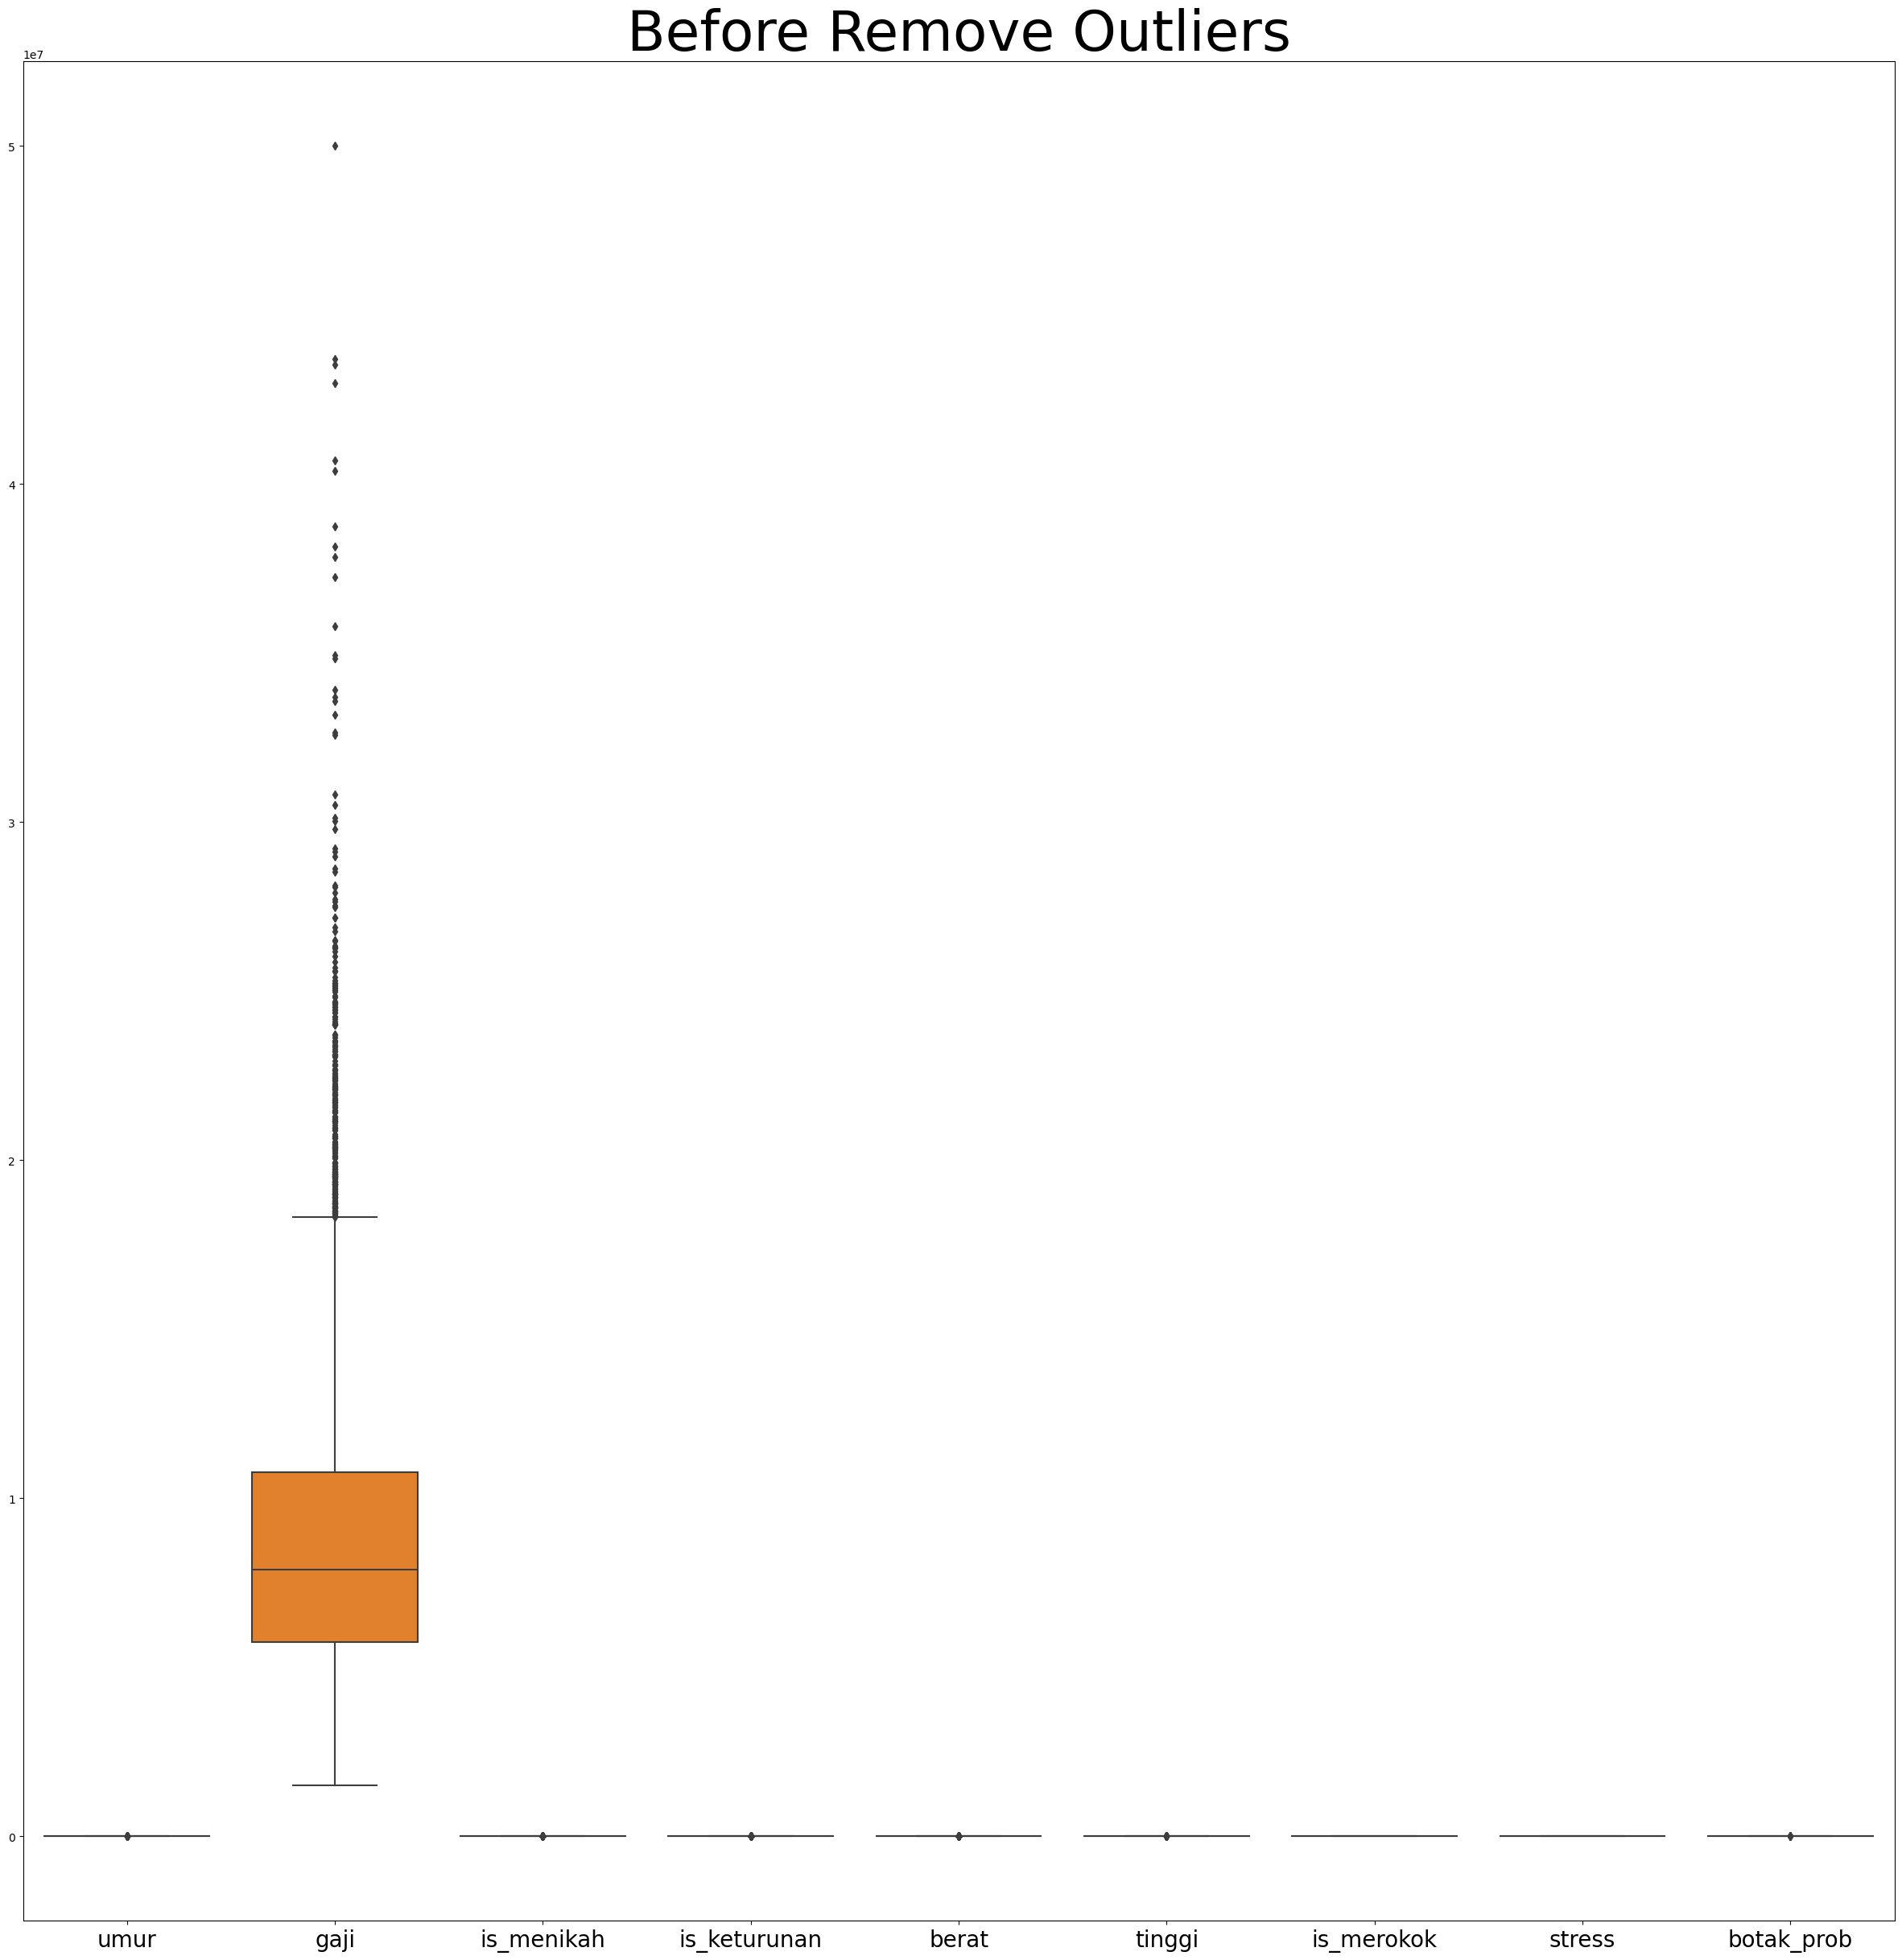

In [37]:
# Melihat outliers
fig, ax = plt.subplots(figsize=(30, 30))
plt.title('Before Remove Outliers', fontsize=50)
sns.boxplot(data=df)
ax.tick_params(axis='x', labelsize=20)
plt.show()

In [38]:
# Z-Score
columns = ['gaji']

for i in columns:
    upper_limit = df[i].mean() + 3*df[i].std()
    lower_limit = df[i].mean() - 3*df[i].std()

    df[i] = np.where(
        df[i]>upper_limit,
        upper_limit,
        np.where(
            df[i]<lower_limit,
            lower_limit,
            df[i]
        )
    )

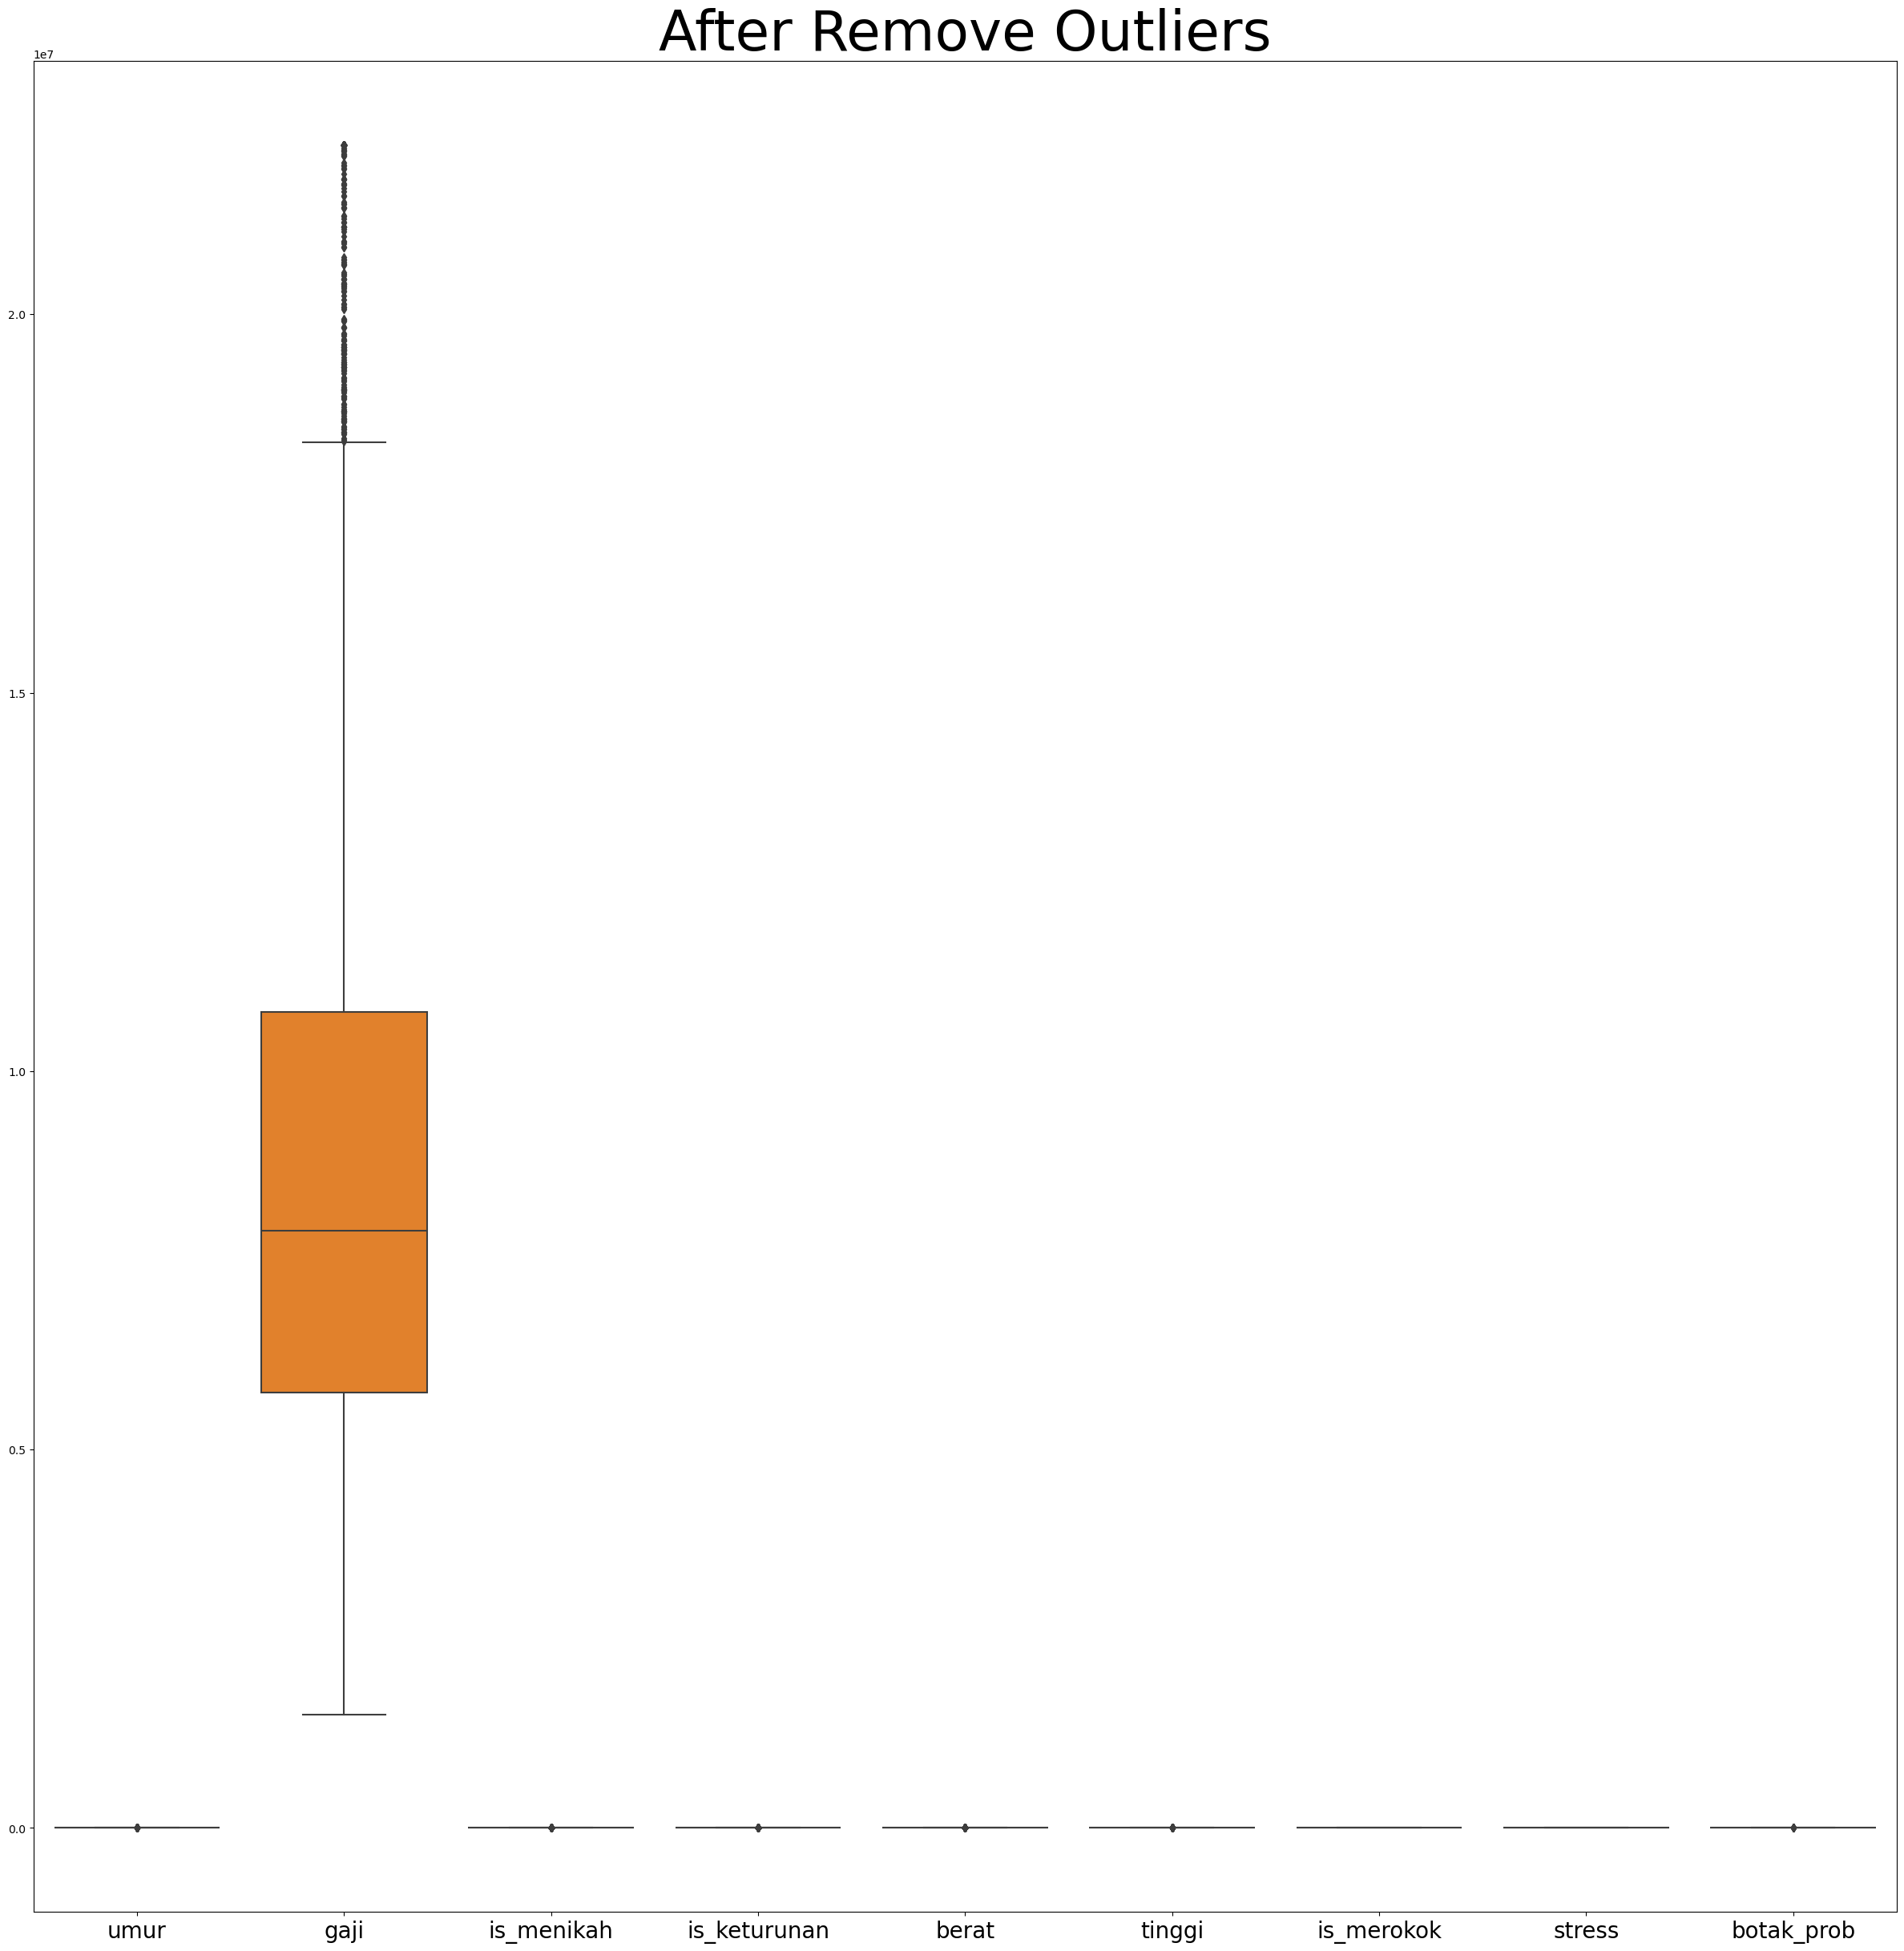

In [39]:
fig, ax = plt.subplots(figsize=(30, 30))
plt.title('After Remove Outliers', fontsize=50)
sns.boxplot(data=df)
ax.tick_params(axis='x', labelsize=20)
plt.show()

## Data Encoding

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7835 entries, 0 to 7834
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   umur           7835 non-null   float64
 1   jenis_kelamin  7835 non-null   object 
 2   pekerjaan      7835 non-null   object 
 3   provinsi       7835 non-null   object 
 4   gaji           7835 non-null   float64
 5   is_menikah     7835 non-null   float64
 6   is_keturunan   7835 non-null   float64
 7   berat          7835 non-null   float64
 8   tinggi         7835 non-null   float64
 9   sampo          7835 non-null   object 
 10  is_merokok     7835 non-null   float64
 11  pendidikan     7835 non-null   object 
 12  stress         7835 non-null   float64
 13  botak_prob     7835 non-null   float64
dtypes: float64(9), object(5)
memory usage: 918.2+ KB


In [41]:
cat = ['jenis_kelamin', 'pekerjaan', 'provinsi', 'sampo', 'pendidikan']
for col in cat:
    print(col)
    print(df[col].unique())
    print('type data:', df[col].dtype)
    print('\n')

jenis_kelamin
['Perempuan' 'Laki-laki']
type data: object


pekerjaan
['PNS' 'Pegawai swasta' 'Pengangguran' 'Freelance' 'Others']
type data: object


provinsi
['Bengkulu' 'Bandung' 'Palu' 'Palangkaraya' 'Serang' 'Banda Aceh'
 'Palembang' 'Kupang' 'Sofifi' 'Ambon' 'Tanjungselor' 'Tanjung Pinang'
 'Banjarmasin' 'Denpasar' 'Mamuju' 'Makassar' 'Pangkalpinang' 'Yogyakarta'
 'Pontianak' 'Mataram' 'Manokwari' 'Gorontalo' 'Semarang' 'Surabaya'
 'Jakarta' 'Banda Lampung' 'Kendari' 'Pekanbaru' 'Jayapura' 'Jambi'
 'Manado' 'Medan' 'Samarinda' 'Others' 'Padang']
type data: object


sampo
['Pantone' 'Moonsilk' 'Deadbuoy' 'Merpati' 'Shoulder & Head' 'Others']
type data: object


pendidikan
['S1' 'SD' 'S2' 'SMA' 'SMP' 'S3' 'Others']
type data: object




In [42]:
# label encoder kolom provinsi, sampo
le = LabelEncoder()
df['provinsi'] = le.fit_transform(df['provinsi'])
df['sampo'] = le.fit_transform(df['sampo'])

In [43]:
# encoding kolom pekerjaan, pendidikan
pekerjaan = {'Pengangguran': 1, 'Others': 2, 'Freelance': 3, 'Pegawai swasta': 4, 'PNS': 5}
df['pekerjaan'] = df['pekerjaan'].replace(pekerjaan)

pendidikan = {'SD': 1, 'SMP': 2, 'SMA': 3, 'Others': 4, 'S1': 5, 'S2': 6, 'S3': 7}
df['pendidikan'] = df['pendidikan'].replace(pendidikan)

In [44]:
# one hot encoder kolom jenis_kelamin
df = pd.get_dummies(df)
df

,umur,pekerjaan,provinsi,gaji,is_menikah,is_keturunan,berat,tinggi,sampo,is_merokok,pendidikan,stress,botak_prob,jenis_kelamin_Laki-laki,jenis_kelamin_Perempuan
0,27.0,5,5,7.957453e+06,1.0,0.0,54.315053,170.428542,4,1.0,5,5.0,0.605974,False,True
1,53.0,5,3,7.633003e+06,1.0,0.0,72.873404,165.530097,4,0.0,5,7.0,0.532860,False,True
2,37.0,4,3,6.637625e+06,1.0,0.0,46.321533,154.599388,2,0.0,5,4.0,0.418442,False,True
3,36.0,1,23,3.624871e+06,1.0,0.0,51.539781,167.340481,0,1.0,1,9.0,0.804050,False,True
4,38.0,3,21,6.031808e+06,1.0,0.0,60.726909,165.514773,1,1.0,6,1.0,0.368371,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7830,52.0,5,16,4.286318e+06,1.0,0.0,46.893444,169.880171,0,1.0,3,2.0,0.773141,True,False
7831,45.0,5,33,8.646146e+06,1.0,0.0,53.878714,170.122857,4,0.0,5,2.0,0.604058,True,False
7832,24.0,5,9,6.850066e+06,1.0,0.0,64.171294,161.384804,2,0.0,3,8.0,0.502413,True,False
7833,29.0,4,21,1.204960e+07,1.0,0.0,55.217752,179.602130,4,1.0,3,6.0,0.562664,True,False


In [45]:
df['jenis_kelamin_Laki-laki'] = df['jenis_kelamin_Laki-laki'].astype(float)
df['jenis_kelamin_Perempuan'] = df['jenis_kelamin_Perempuan'].astype(float)

In [46]:
df.head()

,umur,pekerjaan,provinsi,gaji,is_menikah,is_keturunan,berat,tinggi,sampo,is_merokok,pendidikan,stress,botak_prob,jenis_kelamin_Laki-laki,jenis_kelamin_Perempuan
0,27.0,5,5,7.957453e+06,1.0,0.0,54.315053,170.428542,4,1.0,5,5.0,0.605974,0.0,1.0
1,53.0,5,3,7.633003e+06,1.0,0.0,72.873404,165.530097,4,0.0,5,7.0,0.532860,0.0,1.0
2,37.0,4,3,6.637625e+06,1.0,0.0,46.321533,154.599388,2,0.0,5,4.0,0.418442,0.0,1.0
3,36.0,1,23,3.624871e+06,1.0,0.0,51.539781,167.340481,0,1.0,1,9.0,0.804050,0.0,1.0
4,38.0,3,21,6.031808e+06,1.0,0.0,60.726909,165.514773,1,1.0,6,1.0,0.368371,1.0,0.0


## Normalization and Standarization

In [47]:
df.describe()

,umur,pekerjaan,provinsi,gaji,is_menikah,is_keturunan,berat,tinggi,sampo,is_merokok,pendidikan,stress,botak_prob,jenis_kelamin_Laki-laki,jenis_kelamin_Perempuan
count,7835.000000,7835.000000,7835.000000,7.835000e+03,7835.000000,7835.000000,7835.000000,7835.000000,7835.000000,7835.000000,7835.000000,7835.000000,7835.000000,7835.000000,7835.000000
mean,39.463050,4.081685,16.846203,8.768357e+06,0.970262,0.202680,55.953868,167.238538,2.400766,0.493682,4.278622,5.439056,0.573762,0.686918,0.313082
std,9.835084,0.994735,10.167701,4.141070e+06,0.169875,0.402022,9.554732,10.891418,1.851301,0.499992,1.321779,2.854475,0.172662,0.463777,0.463777
min,2.000000,1.000000,0.000000,1.500000e+06,0.000000,0.000000,40.000000,125.491784,0.000000,0.000000,1.000000,1.000000,0.064633,0.000000,0.000000
25%,33.000000,4.000000,8.000000,5.752457e+06,1.000000,0.000000,49.347849,159.797520,1.000000,0.000000,3.000000,3.000000,0.453389,0.000000,0.000000
50%,39.000000,4.000000,16.000000,7.886191e+06,1.000000,0.000000,53.921956,167.238538,2.000000,0.000000,5.000000,5.000000,0.570483,1.000000,0.000000
75%,46.000000,5.000000,26.000000,1.077803e+07,1.000000,0.000000,60.226677,174.356880,4.000000,1.000000,5.000000,8.000000,0.685767,1.000000,1.000000
max,77.000000,5.000000,34.000000,2.223376e+07,1.000000,1.000000,150.000000,226.454577,5.000000,1.000000,7.000000,10.000000,1.000000,1.000000,1.000000


In [48]:
df['umur'] = MinMaxScaler().fit_transform(df[['umur']])
df['berat'] = MinMaxScaler().fit_transform(df[['berat']])
df['tinggi'] = MinMaxScaler().fit_transform(df[['tinggi']])
df['gaji'] = StandardScaler().fit_transform(df[['gaji']])

In [49]:
df.describe()

,umur,pekerjaan,provinsi,gaji,is_menikah,is_keturunan,berat,tinggi,sampo,is_merokok,pendidikan,stress,botak_prob,jenis_kelamin_Laki-laki,jenis_kelamin_Perempuan
count,7835.000000,7835.000000,7835.000000,7.835000e+03,7835.000000,7835.000000,7835.000000,7835.000000,7835.000000,7835.000000,7835.000000,7835.000000,7835.000000,7835.000000,7835.000000
mean,0.499507,4.081685,16.846203,-4.879030e-16,0.970262,0.202680,0.145035,0.413487,2.400766,0.493682,4.278622,5.439056,0.573762,0.686918,0.313082
std,0.131134,0.994735,10.167701,1.000064e+00,0.169875,0.402022,0.086861,0.107876,1.851301,0.499992,1.321779,2.854475,0.172662,0.463777,0.463777
min,0.000000,1.000000,0.000000,-1.755300e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.064633,0.000000,0.000000
25%,0.413333,4.000000,8.000000,-7.283366e-01,1.000000,0.000000,0.084980,0.339786,1.000000,0.000000,3.000000,3.000000,0.453389,0.000000,0.000000
50%,0.493333,4.000000,16.000000,-2.130422e-01,1.000000,0.000000,0.126563,0.413487,2.000000,0.000000,5.000000,5.000000,0.570483,1.000000,0.000000
75%,0.586667,5.000000,26.000000,4.853327e-01,1.000000,0.000000,0.183879,0.483991,4.000000,1.000000,5.000000,8.000000,0.685767,1.000000,1.000000
max,1.000000,5.000000,34.000000,3.251880e+00,1.000000,1.000000,1.000000,1.000000,5.000000,1.000000,7.000000,10.000000,1.000000,1.000000,1.000000


# Baseline Model

In [50]:
X = df.drop(['botak_prob'], axis=1)
y = df['botak_prob']

In [51]:
# split train-test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0)

In [52]:
# Machine learning Model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.linear_model import BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures

# Cross Validation
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold

# Evaluation
from sklearn import metrics
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.metrics import make_scorer,accuracy_score,roc_auc_score,precision_score,recall_score,f1_score,log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, max_error

In [53]:
# Modelling Algorithms
kf = KFold(n_splits=5, shuffle=True, random_state=42)

## Collect all model in one list
all_model = [LinearRegression,
             Ridge,
             Lasso,
             ElasticNet,
             SVR,
             BayesianRidge,
             KNeighborsRegressor,
             SGDRegressor,
             DecisionTreeRegressor,
             RandomForestRegressor,
             GradientBoostingRegressor,
             XGBRegressor]

model_name = ['LinearRegression',
              'Ridge',
              'Lasso',
              'ElasticNet',
              'SVR',
              'BayesianRidge',
              'KNeighborsRegressor',
              'SGDRegressor',
              'DecisionTreeRegressor',
              'RandomForestRegressor',
              'GradientBoostingRegressor',
              'XGBRegressor']

## loop for all model
mae_scores = []
mse_scores = []
rmse_scores = []
r2_scores = []
max_err_scores = []

for idx, model_type in enumerate(all_model):
    mae_temp = []
    mse_temp = []
    rmse_temp = []
    r2_temp = []
    max_err_temp = []
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]

        model = model_type()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mae_temp.append(mean_absolute_error(y_test, y_pred))
        mse_temp.append(mean_squared_error(y_test, y_pred))
        rmse_temp.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        r2_temp.append(r2_score(y_test, y_pred))
        max_err_temp.append(max_error(y_test, y_pred))

    mae_scores.append(np.mean(mae_temp))
    mse_scores.append(np.mean(mse_temp))
    rmse_scores.append(np.mean(rmse_temp))
    r2_scores.append(np.mean(r2_temp))
    max_err_scores.append(np.mean(max_err_temp))

In [54]:
# compare model each other
data_hasil = pd.DataFrame()
data_hasil['model'] = model_name
data_hasil['MAE'] = mae_scores
data_hasil['MSE'] = mse_scores
data_hasil['RMSE'] = rmse_scores
data_hasil['R2']= r2_scores
data_hasil['Max Error']= max_err_scores
data_hasil.sort_values(by='MAE', ascending=True)

,model,MAE,MSE,RMSE,R2,Max Error
10,GradientBoostingRegressor,0.047209,0.004503,0.067074,0.848958,0.684327
9,RandomForestRegressor,0.051968,0.005335,0.073018,0.820995,0.724151
11,XGBRegressor,0.052132,0.005416,0.073588,0.818126,0.716441
8,DecisionTreeRegressor,0.070973,0.009999,0.099964,0.664266,0.813502
4,SVR,0.075292,0.010092,0.100433,0.661418,0.632270
0,LinearRegression,0.085901,0.013451,0.115954,0.548611,0.648513
5,BayesianRidge,0.085910,0.013451,0.115955,0.548610,0.648222
1,Ridge,0.085916,0.013451,0.115955,0.548608,0.648058
6,KNeighborsRegressor,0.113852,0.020804,0.144200,0.301777,0.612432
2,Lasso,0.137685,0.029817,0.172658,-0.000777,0.490678


## Polynomial Regression 

In [55]:
X = df.drop(['botak_prob'], axis=1)
y = df['botak_prob']

In [56]:
# split train-test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0)

In [57]:
polynomial_converter = PolynomialFeatures(degree=2,include_bias=False)
poly_features = polynomial_converter.fit_transform(X)

In [58]:
model_pr = LinearRegression(fit_intercept=True)
model_pr.fit(X_train,y_train)

LinearRegression()

In [59]:
y_pred = model_pr.predict(X_test)
#MAE = mean_absolute_error(y_test, y_pred)
#MSE = mean_squared_error(y_test, y_pred)
#RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
#R2 = r2_score(y_test, y_pred)
#Max_Error = max_error(y_test, y_pred)
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2:', r2_score(y_test, y_pred))
print('Max_Error:', max_error(y_test, y_pred))

MAE: 0.08784102977494222
MSE: 0.013473481293172239
RMSE: 0.11607532594471677
R2: 0.5672541892902547
Max_Error: 0.6194668576328071


# Hyperparameter

In [60]:
model = GradientBoostingRegressor()

In [61]:
params = {'loss': ['squared_error', 'absolute_error', 'huber', 'quantile'], 
          'learning_rate': [0.1, 0.5], 
          'n_estimators': [100, 300], 
          'subsample': [0.5, 1], 
          'criterion': ['friedman_mse', 'squared_error']}

In [62]:
gbr_grid = GridSearchCV(model, params, cv=10, n_jobs=-1)

In [63]:
gbr_grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'criterion': ['friedman_mse', 'squared_error'],
                         'learning_rate': [0.1, 0.5],
                         'loss': ['squared_error', 'absolute_error', 'huber',
                                  'quantile'],
                         'n_estimators': [100, 300], 'subsample': [0.5, 1]})

In [64]:
print('Best Parameters:', gbr_grid.best_params_)
print('MAE:', mean_absolute_error(y_test, gbr_grid.predict(X_test)))
print('MSE:', mean_squared_error(y_test, gbr_grid.predict(X_test)))
print('RMSE:', np.sqrt(mean_squared_error(y_test, gbr_grid.predict(X_test))))
print('R2:', r2_score(y_test, gbr_grid.predict(X_test)))
print('Max_Error:', max_error(y_test, gbr_grid.predict(X_test)))

Best Parameters: {'criterion': 'squared_error', 'learning_rate': 0.1, 'loss': 'huber', 'n_estimators': 100, 'subsample': 1}
MAE: 0.04580490019267085
MSE: 0.004170573112546951
RMSE: 0.06457997454743189
R2: 0.8660481279156866
Max_Error: 0.7237980540966279
